In [1]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import pandas.util.testing as tm

import seaborn as sns
import statsmodels.formula.api as sm

#%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

<ipython-input-1-5a54db6840c5>:5: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Import data

In [2]:
df = pd.read_excel('DatasetEN.xlsx',index_col=0) #load data
print(df.shape)
df

(49028, 22)


,Status,Target date,Closed,Category,Subcategory,Call Type,Department,Call Date,Number of days current,Department.1,...,Time spent for Second Line,Date/time of creation,Date/time of change,Closure Date,Completion Date,Duration,Actual duration,Escalated,Major call,Entry
Line,,,,,,,,,,,,,,,,,,,,,
Second line call,Onterecht aangemaakt,2015-01-23 10:54:00,True,ICT SAP,SD (Verkoop),ICT Verstoring,NaN,2013-11-22 08:54:00,288,Klantenservice - Klantenservice-A - K&O,...,00:00:00,2013-11-22 08:54:34,2015-01-15 13:14:12,2015-01-15 13:14:00,2015-01-15 13:14:00,2 uur,1900-05-22 09:20:00,True,NaN,E-mail
Second line call,Afgehandeld,2015-09-18 11:52:00,True,ICT GIS,Smallworld NRM,ICT Verstoring,NaN,2014-06-04 11:52:00,322,Aanleg Leidingen - Aansluitleidingen - K&O,...,00:00:00,2014-06-04 11:52:15,2015-09-10 12:52:18,2015-09-10 12:52:00,2015-09-10 12:52:00,5 dagen,1900-06-08 09:30:00,True,NaN,E-mail
Second line call,Afgehandeld,2016-12-30 18:00:00,True,ICT GIS,Arcgis,ICT Verstoring,NaN,2014-07-21 15:15:00,183,NaN,...,00:00:00,2014-07-21 15:21:58,2015-04-08 07:57:11,2015-04-08 07:57:00,2015-04-08 07:57:00,5 dagen,1900-03-31 01:12:00,True,NaN,Telefonisch
Second line call,Afgehandeld,2015-07-17 15:45:00,True,ICT Infra,Netwerkverbinding,ICT Verstoring,NaN,2014-10-09 15:45:00,169,Productie - Centraal - K&O,...,00:00:00,2014-10-09 15:45:51,2015-06-16 14:28:58,2015-06-16 14:28:00,2015-06-16 14:28:00,5 dagen,1900-03-24 07:13:00,True,NaN,E-mail
Second line call,Afgehandeld,2015-02-27 10:42:00,True,ICT Overige applicaties,Kijk op water,ICT Vraag,NaN,2014-10-20 10:42:00,75,Onderhoud & Inspectie - Inspectie & Kwal. - K&O,...,00:00:00,2014-10-20 10:42:31,2015-02-05 09:10:00,2015-02-05 09:09:00,2015-02-05 09:09:00,5 dagen,1900-02-06 06:57:00,True,NaN,E-mail
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
First line call,Omgezet naar wijziging,2021-03-15 07:58:00,True,ICT GIS,Smallworld NRM,ICT Service Request,K&O - Aanleg leidingen - HAL,2021-03-12 15:58:00,0,Aanleg leidingen - K&O,...,00:00:00,2021-03-12 15:58:11,2021-03-12 16:24:37,2021-03-12 16:24:00,2021-03-12 16:24:00,4 uur,00:26:00,False,NaN,E-mail
First line call,Onterecht aangemaakt,2021-03-15 11:00:00,True,-,-,ICT Vraag,BO - ICT - ICT Service & Infra,2021-03-13 10:32:00,0,ICT - ICT Services & Infra - BO,...,00:00:00,2021-03-13 10:32:51,2021-03-13 14:13:56,2021-03-13 14:13:00,2021-03-13 14:13:00,4 uur,00:00:00,False,NaN,E-mail
First line call,Onterecht aangemaakt,2021-03-15 11:00:00,True,-,-,ICT Vraag,BO - ICT - ICT Service & Infra,2021-03-13 12:22:00,0,ICT - ICT Services & Infra - BO,...,00:00:00,2021-03-13 12:22:56,2021-03-13 14:14:02,2021-03-13 14:14:00,2021-03-13 14:14:00,4 uur,00:00:00,False,NaN,E-mail


In [3]:
df.keys()

Index(['Status', 'Target date', 'Closed', 'Category', 'Subcategory',
       'Call Type', 'Department', 'Call Date', 'Number of days current',
       'Department.1', 'Operator Group', 'Time spent for First line',
       'Time spent for Second Line', 'Date/time of creation',
       'Date/time of change', 'Closure Date', 'Completion Date', 'Duration',
       'Actual duration', 'Escalated', 'Major call', 'Entry'],
      dtype='object')

In [4]:
df.shape
pd.__version__

'1.1.4'

## EDA

### Filter important columns

In [5]:
df = df[['Status', 'Target date','Category','Subcategory','Call Type','Department.1','Operator Group','Date/time of creation','Closure Date','Duration','Entry']]
df = df.reset_index()

In [6]:
oldsize = df.shape
oldsize

(49028, 12)

Create a column that represents the total duration of a call:

In [7]:
df['actual duration'] = df['Closure Date'] - df['Date/time of creation']

In [8]:
df.head()

,Line,Status,Target date,Category,Subcategory,Call Type,Department.1,Operator Group,Date/time of creation,Closure Date,Duration,Entry,actual duration
0,Second line call,Onterecht aangemaakt,2015-01-23 10:54:00,ICT SAP,SD (Verkoop),ICT Verstoring,Klantenservice - Klantenservice-A - K&O,ICT ServiceDesk,2013-11-22 08:54:34,2015-01-15 13:14:00,2 uur,E-mail,419 days 04:19:26
1,Second line call,Afgehandeld,2015-09-18 11:52:00,ICT GIS,Smallworld NRM,ICT Verstoring,Aanleg Leidingen - Aansluitleidingen - K&O,ICT ServiceDesk,2014-06-04 11:52:15,2015-09-10 12:52:00,5 dagen,E-mail,463 days 00:59:45
2,Second line call,Afgehandeld,2016-12-30 18:00:00,ICT GIS,Arcgis,ICT Verstoring,NaN,ICT Technisch beheer,2014-07-21 15:21:58,2015-04-08 07:57:00,5 dagen,Telefonisch,260 days 16:35:02
3,Second line call,Afgehandeld,2015-07-17 15:45:00,ICT Infra,Netwerkverbinding,ICT Verstoring,Productie - Centraal - K&O,ICT Technisch beheer,2014-10-09 15:45:51,2015-06-16 14:28:00,5 dagen,E-mail,249 days 22:42:09
4,Second line call,Afgehandeld,2015-02-27 10:42:00,ICT Overige applicaties,Kijk op water,ICT Vraag,Onderhoud & Inspectie - Inspectie & Kwal. - K&O,ICT Technisch beheer,2014-10-20 10:42:31,2015-02-05 09:09:00,5 dagen,E-mail,107 days 22:26:29


In [9]:
df.keys()

Index(['Line', 'Status', 'Target date', 'Category', 'Subcategory', 'Call Type',
       'Department.1', 'Operator Group', 'Date/time of creation',
       'Closure Date', 'Duration', 'Entry', 'actual duration'],
      dtype='object')

### Remove categorical entries that are not sufficiently represented in the dataset:

In [10]:
df.dtypes

Line                              object
Status                            object
Target date               datetime64[ns]
Category                          object
Subcategory                       object
Call Type                         object
Department.1                      object
Operator Group                    object
Date/time of creation     datetime64[ns]
Closure Date              datetime64[ns]
Duration                          object
Entry                             object
actual duration          timedelta64[ns]
dtype: object

Describe the categorical variables

In [11]:
df[['Status', 'Category', 'Subcategory', 'Call Type',
       'Department.1', 'Operator Group','Duration', 'Entry','Line']].describe()

,Status,Category,Subcategory,Call Type,Department.1,Operator Group,Duration,Entry,Line
count,49028,49028,49028,49028,41778,49028,49028,49028,49028
unique,5,29,200,24,76,10,9,9,2
top,Afgehandeld,ICT Infra,-,ICT Vraag,ICT - ICT Services & Infra - BO,ICT ServiceDesk,2 uur,E-mail,First line call
freq,30171,11714,10551,18581,2977,44450,34191,27559,38507


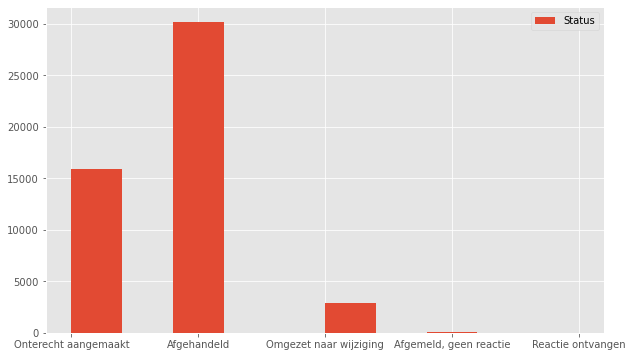

In [12]:
status_type = df['Status']
status_type.hist(legend = bool)

Only afgehandeld is relevant, onterecht aangemaakt is spam en automatic logging or wrong mails

In [13]:
df = df[df["Status"].str.contains("Afgehandeld", case = False)]
df.shape

(30171, 13)

Perform similar cleaning on other categorical features

In [14]:
#remove call with a category type that is not properly represented
category_type = df['Category']
category_type.value_counts()
g = df.groupby('Category')
df = g.filter(lambda x: len(x) > 10)

#do the same for subcategory
category_type = df['Subcategory']
category_type.value_counts()
g = df.groupby('Subcategory')
df = g.filter(lambda x: len(x) > 10)

#remove call type instances
call_type = df['Call Type']
call_type.value_counts()
g = df.groupby('Call Type')
df = g.filter(lambda x: len(x) > 10)


#remove department type instances
department_type = df['Department.1']
department_type.value_counts()
g = df.groupby('Department.1')
df = g.filter(lambda x: len(x) > 10)

#remove poor represented operator groups
operator_type = df['Operator Group']
operator_type.value_counts()
g = df.groupby('Operator Group')
df = g.filter(lambda x: len(x) > 10)

df.shape

(27038, 13)

We decided to remove instances that contain a unique category that, in other words categories that contain less than 10 instances. In the company there have been several changes over the years and could explain why some of these category types are not used often/anymore and that is why we decided to remove them. 

Some categories are bullshit or were only used for temporary projects so they are not relevant anymore.

#### We look specifically at the entry types because it relates to one of our research questions

In [15]:
entry_type = df['Entry']
entry_type.value_counts()

Telefonisch           13501
E-mail                 9354
Persoonlijk            2872
SelfServiceDesk        1020
Topdesk Formulier       247
Skype                    22
Zelf geconstateerd       14
FO-mail                   7
PA-mail                   1
Name: Entry, dtype: int64

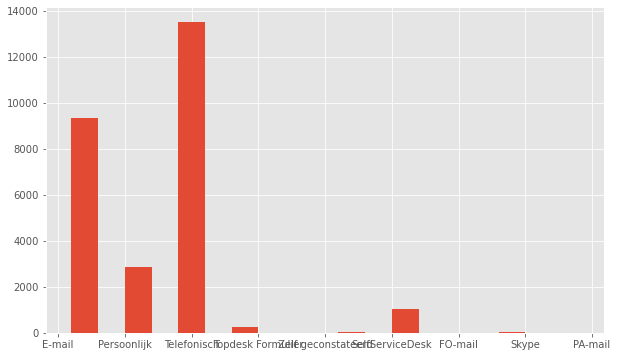

In [16]:
entry_type.hist(rwidth=0.5)

In [17]:
df = df[df["Entry"].str.contains("E-mail", case = False) | df["Entry"].str.contains("Telefonisch", case = False) | df["Entry"].str.contains("Persoonlijk", case = False)| df["Entry"].str.contains("SelfServiceDesk", case = False)]

In [18]:
print(oldsize)
print(df.shape)

(49028, 12)
(26747, 13)


We managed to filter out a lot of instances that are not sufficiently represented. Since we have a lot of data we decided to remove them from the dataset just for convenience. 

### Remove outliers in the numeric data:

Describe the numeric variables

In [19]:
df[['Target date', 'Date/time of creation', 'Closure Date', 'actual duration']].describe(datetime_is_numeric=True)

,Target date,Date/time of creation,Closure Date,actual duration
count,26747,26747,26747,26747
mean,2017-12-31 09:02:23.304898304,2017-12-26 03:44:59.272110336,2017-12-29 23:29:13.375710208,3 days 19:44:14.103600405
min,2014-12-23 16:24:00,2014-06-04 11:52:15,2015-01-05 08:34:00,-1 days +21:04:19
25%,2016-05-25 18:20:30,2016-05-23 16:26:38,2016-05-25 08:45:30,-1 days +23:59:42
50%,2017-11-13 08:51:45,2017-11-07 08:01:06,2017-11-09 14:32:00,0 days 00:18:22
75%,2019-08-29 15:38:00,2019-08-20 09:34:57,2019-08-28 09:09:30,0 days 08:43:23.500000
max,2024-07-31 18:00:00,2021-03-12 13:48:20,2021-03-12 15:30:00,1653 days 02:58:58
std,NaN,NaN,NaN,26 days 15:00:39.565864100


Create a column that represent the duration as a numeric value instead of a date time value for easier analysis:

In [20]:
df['actual duration seconds'] = df['actual duration'].apply(lambda x : x.total_seconds())
df['actual duration minutes'] = df['actual duration'].apply(lambda x : x.total_seconds()/60)

In [21]:
df[['Target date', 'Date/time of creation', 'Closure Date', 'actual duration','actual duration seconds','actual duration minutes']].describe(datetime_is_numeric=True)

,Target date,Date/time of creation,Closure Date,actual duration,actual duration seconds,actual duration minutes
count,26747,26747,26747,26747,2.674700e+04,2.674700e+04
mean,2017-12-31 09:02:23.304898304,2017-12-26 03:44:59.272110336,2017-12-29 23:29:13.375710208,3 days 19:44:14.103600405,3.302541e+05,5.504235e+03
min,2014-12-23 16:24:00,2014-06-04 11:52:15,2015-01-05 08:34:00,-1 days +21:04:19,-1.054100e+04,-1.756833e+02
25%,2016-05-25 18:20:30,2016-05-23 16:26:38,2016-05-25 08:45:30,-1 days +23:59:42,-1.800000e+01,-3.000000e-01
50%,2017-11-13 08:51:45,2017-11-07 08:01:06,2017-11-09 14:32:00,0 days 00:18:22,1.102000e+03,1.836667e+01
75%,2019-08-29 15:38:00,2019-08-20 09:34:57,2019-08-28 09:09:30,0 days 08:43:23.500000,3.140350e+04,5.233917e+02
max,2024-07-31 18:00:00,2021-03-12 13:48:20,2021-03-12 15:30:00,1653 days 02:58:58,1.428299e+08,2.380499e+06
std,NaN,NaN,NaN,26 days 15:00:39.565864100,2.300440e+06,3.834066e+04


Plot the distribution of the duration:

Remove the outliers in duration

In [22]:
df['Line_Type_num'] = df['Line'].str.contains('Second line call').astype(int)
df

,Line,Status,Target date,Category,Subcategory,Call Type,Department.1,Operator Group,Date/time of creation,Closure Date,Duration,Entry,actual duration,actual duration seconds,actual duration minutes,Line_Type_num
1,Second line call,Afgehandeld,2015-09-18 11:52:00,ICT GIS,Smallworld NRM,ICT Verstoring,Aanleg Leidingen - Aansluitleidingen - K&O,ICT ServiceDesk,2014-06-04 11:52:15,2015-09-10 12:52:00,5 dagen,E-mail,463 days 00:59:45,40006785.0,666779.750000,1
3,Second line call,Afgehandeld,2015-07-17 15:45:00,ICT Infra,Netwerkverbinding,ICT Verstoring,Productie - Centraal - K&O,ICT Technisch beheer,2014-10-09 15:45:51,2015-06-16 14:28:00,5 dagen,E-mail,249 days 22:42:09,21595329.0,359922.150000,1
4,Second line call,Afgehandeld,2015-02-27 10:42:00,ICT Overige applicaties,Kijk op water,ICT Vraag,Onderhoud & Inspectie - Inspectie & Kwal. - K&O,ICT Technisch beheer,2014-10-20 10:42:31,2015-02-05 09:09:00,5 dagen,E-mail,107 days 22:26:29,9325589.0,155426.483333,1
5,Second line call,Afgehandeld,2015-02-27 14:55:00,ICT Overige applicaties,Kijk op water,ICT Verstoring,Onderhoud & Inspectie - Inspectie & Kwal. - K&O,ICT Technisch beheer,2014-11-12 14:55:23,2015-02-25 07:58:00,5 dagen,E-mail,104 days 17:02:37,9046957.0,150782.616667,1
7,Second line call,Afgehandeld,2015-02-27 10:24:00,ICT MS Applicaties,Outlook,ICT Verstoring,Projectmanagement - M&I,ICT Technisch beheer,2014-11-18 10:26:04,2015-02-11 09:31:00,5 dagen,Persoonlijk,84 days 23:04:56,7340696.0,122344.933333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49002,First line call,Afgehandeld,2021-03-11 16:06:00,ICT Telefonie,Vaste telefonie,ICT Service Request,Personeel & Advisering - KAM - BO,ICT ServiceDesk,2021-03-11 12:06:34,2021-03-11 12:24:00,4 uur,E-mail,0 days 00:17:26,1046.0,17.433333,0
49008,Second line call,Afgehandeld,2021-03-18 15:14:00,ICT GIS,Smallworld NRM,ICT Service Request,Aanleg leidingen - K&O,ICT GIS Functioneel Applicatiebeheer,2021-03-11 15:14:27,2021-03-12 15:02:00,5 dagen,E-mail,0 days 23:47:33,85653.0,1427.550000,1
49017,First line call,Afgehandeld,2021-03-12 14:50:00,ICT Werkplek,Tablet,ICT Service Request,Distributie - Distributie Noord - K&O,ICT ServiceDesk,2021-03-12 10:53:02,2021-03-12 10:53:00,4 uur,Persoonlijk,-1 days +23:59:58,-2.0,-0.033333,0
49018,Second line call,Afgehandeld,2021-03-19 10:52:00,ICT SAP,MM (Inkoop & Logistiek),ICT Vraag,Aanleg leidingen - K&O,ICT SAP Functioneel Applicatiebeheer,2021-03-12 10:52:30,2021-03-12 11:33:00,5 dagen,E-mail,0 days 00:40:30,2430.0,40.500000,1


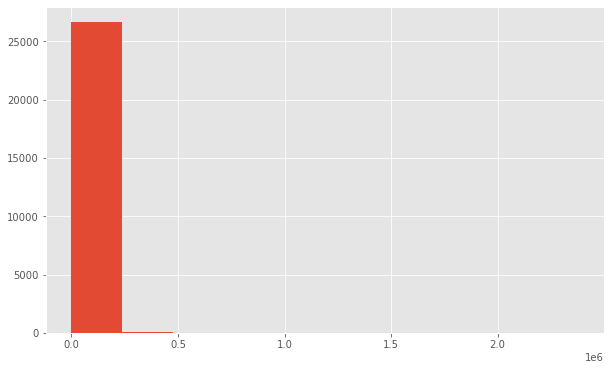

(26747, 16)


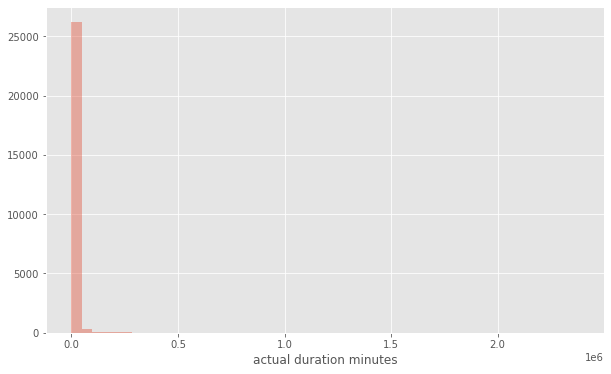

In [23]:
df['actual duration'].astype('timedelta64[m]').hist()
plt.show()

sns.distplot(df['actual duration minutes'], label = df['Line'], kde= False)
print(df.shape)



In [24]:
df = df[df['actual duration']>pd.Timedelta(0,'s')]
df = df[df['actual duration']< pd.Timedelta(30,'d')]
df[['Target date', 'Date/time of creation', 'Closure Date', 'actual duration']].describe(datetime_is_numeric=True)

,Target date,Date/time of creation,Closure Date,actual duration
count,17112,17112,17112,17112
mean,2018-02-11 01:31:46.690743040,2018-02-06 22:51:37.627222784,2018-02-09 02:30:40.807692032,2 days 03:39:03.180458158
min,2014-12-23 16:24:00,2014-12-11 15:29:22,2015-01-05 08:53:00,0 days 00:00:01
25%,2016-07-29 18:12:45,2016-07-27 04:42:07.500000,2016-07-28 15:32:30,0 days 00:17:54
50%,2018-01-22 11:01:30,2018-01-16 16:04:40,2018-01-19 11:59:30,0 days 01:27:32.500000
75%,2019-09-26 22:33:45,2019-09-21 06:21:36.750000128,2019-09-24 21:16:45,1 days 19:14:12
max,2021-03-31 19:00:00,2021-03-12 10:52:30,2021-03-12 15:30:00,29 days 23:46:26
std,NaN,NaN,NaN,4 days 14:44:53.460891384


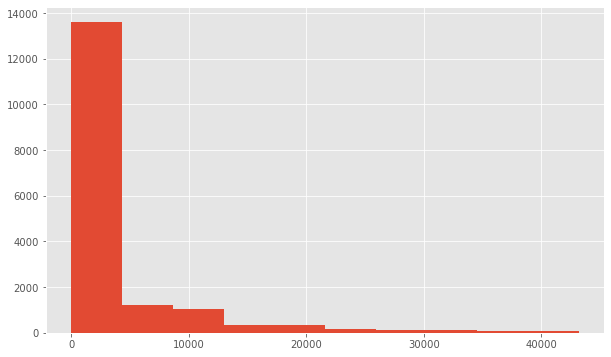

(17112, 16)


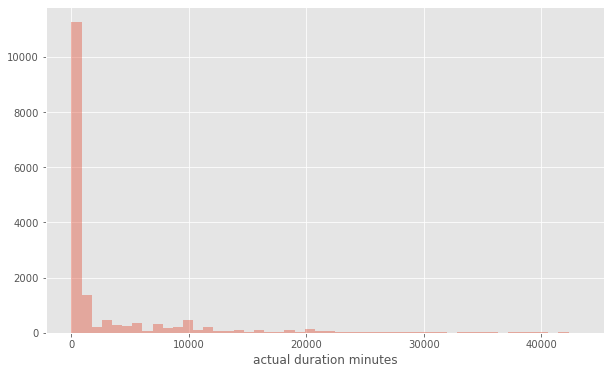

In [25]:
df['actual duration'].astype('timedelta64[m]').hist()
plt.show()

sns.distplot(df['actual duration minutes'], label = df['Line'], kde= False)
print(df.shape)

In [26]:
df

,Line,Status,Target date,Category,Subcategory,Call Type,Department.1,Operator Group,Date/time of creation,Closure Date,Duration,Entry,actual duration,actual duration seconds,actual duration minutes,Line_Type_num
14,Second line call,Afgehandeld,2015-01-30 15:13:00,ICT Overige applicaties,Java,ICT Verstoring,Inkoop & Financiën - Financiën - BO,ICT Technisch beheer,2014-12-11 15:29:22,2015-01-08 08:15:00,5 dagen,Telefonisch,27 days 16:45:38,2393138.0,39885.633333,1
15,Second line call,Afgehandeld,2014-12-23 16:24:00,ICT Overige applicaties,Internet Explorer,ICT Verstoring,Inkoop & Financiën - Inkoop - BO,ICT Technisch beheer,2014-12-12 16:24:13,2015-01-06 11:06:00,5 dagen,E-mail,24 days 18:41:47,2140907.0,35681.783333,1
20,Second line call,Afgehandeld,2014-12-24 19:00:00,ICT MS Applicaties,Outlook,ICT Verstoring,Productie - K&O,ICT Technisch beheer,2014-12-18 16:18:43,2015-01-06 11:06:00,5 dagen,E-mail,18 days 18:47:17,1622837.0,27047.283333,1
21,Second line call,Afgehandeld,2015-01-16 18:56:00,ICT Werkplek,Laptop,ICT Verstoring,Distributie - P&W Distributie - K&O,ICT ServiceDesk,2014-12-19 09:01:22,2015-01-16 15:31:00,5 dagen,Telefonisch,28 days 06:29:38,2442578.0,40709.633333,1
25,Second line call,Afgehandeld,2015-01-14 17:00:00,ICT Telefonie,Smartphone,ICT Verstoring,Onderhoud & Inspectie - Onderhoud - K&O,ICT ServiceDesk,2014-12-23 10:20:55,2015-01-14 12:04:00,5 dagen,Telefonisch,22 days 01:43:05,1906985.0,31783.083333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48998,First line call,Afgehandeld,2021-03-11 19:00:00,ICT Infra,Windows account / AD,ICT Vraag,Personeel & Advisering - HRM - BO,ICT ServiceDesk,2021-03-11 10:29:02,2021-03-11 16:00:00,4 uur,E-mail,0 days 05:30:58,19858.0,330.966667,0
49000,First line call,Afgehandeld,2021-03-11 15:48:00,ICT Telefonie,Smartphone,ICT Vraag,Personeel & Advisering - KAM - BO,ICT ServiceDesk,2021-03-11 11:48:25,2021-03-11 12:04:00,4 uur,E-mail,0 days 00:15:35,935.0,15.583333,0
49002,First line call,Afgehandeld,2021-03-11 16:06:00,ICT Telefonie,Vaste telefonie,ICT Service Request,Personeel & Advisering - KAM - BO,ICT ServiceDesk,2021-03-11 12:06:34,2021-03-11 12:24:00,4 uur,E-mail,0 days 00:17:26,1046.0,17.433333,0
49008,Second line call,Afgehandeld,2021-03-18 15:14:00,ICT GIS,Smallworld NRM,ICT Service Request,Aanleg leidingen - K&O,ICT GIS Functioneel Applicatiebeheer,2021-03-11 15:14:27,2021-03-12 15:02:00,5 dagen,E-mail,0 days 23:47:33,85653.0,1427.550000,1


### Q1: Does the workload vary depending on time of year/ time of the month / day of the week /hour of the day?

#### Time series analysis

Check if there is some change in duration of calls over time

In [27]:
after2014 = df[df["Date/time of creation"]>=np.datetime64('2015-01-01')]

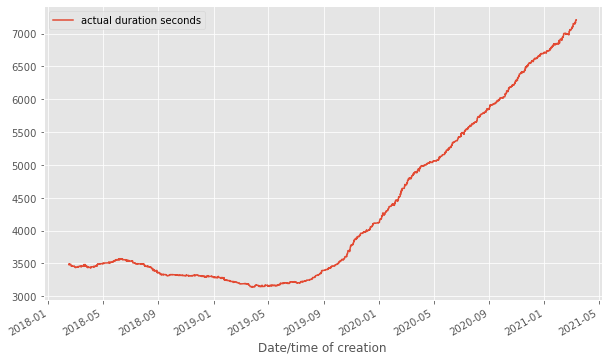

In [28]:
after2014[["Date/time of creation","actual duration seconds"]].set_index("Date/time of creation").rolling(24*365).median().plot()

#### There seems to be a increase in call durations over the years, but we are more interested in seasonality.
We averaged the times series over a window to get a general trend of the years. The increase in duration could be due to changes in company policy. To fully answer our research question we are going to look into the amount of incoming calls over different parts of the day.

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 365  # yearly seasonality
model = 'additive'

decomposition = seasonal_decompose(
    df.set_index("Date/time of creation")['actual duration seconds'].interpolate("linear"),
    freq=decompfreq,
    model=model)

trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

<ipython-input-30-ebb349202580>:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(


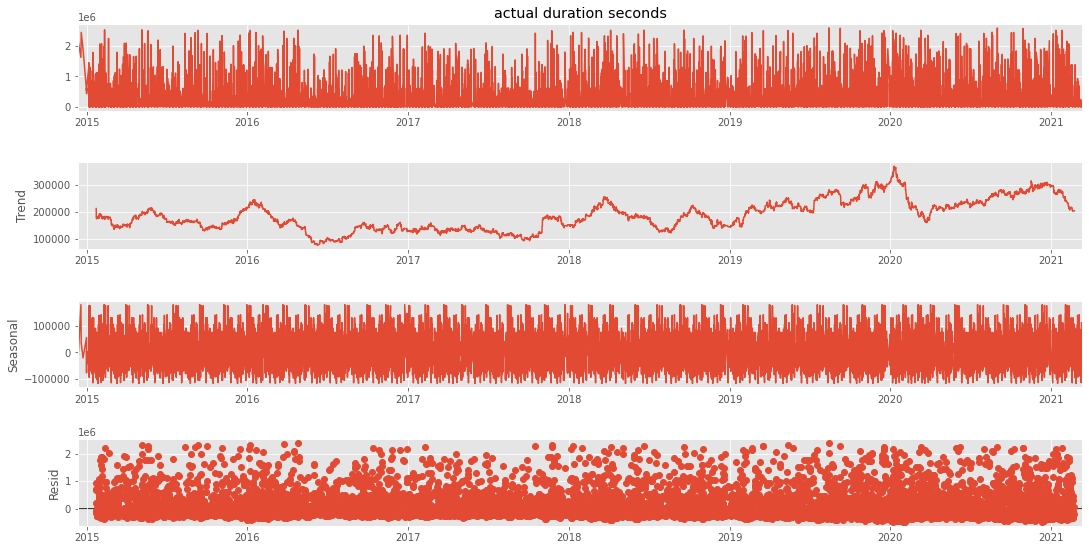

In [31]:
fig = decomposition.plot()
fig.set_size_inches(16, 8)


It is not possible to see any seasonality in terms of duration of calls, hence we are going to use a different approach to define the workload. 

#### We will count the amount of incomming calls for a given period and use this as a measurement of the workload.

In [79]:
df['creation hour of day'] = df['Date/time of creation'].dt.hour
df['monthly incoming'] = df['Date/time of creation'].dt.month
df['creation day of week'] = df['Date/time of creation'].dt.weekday
df['creation day of year'] = df['Date/time of creation'].dt.isocalendar().week


The following plot shows at which hours of the day the most calls are incomming. The calls are selected based on entry type to see if there are difference in workload depending on the entrytype of a call

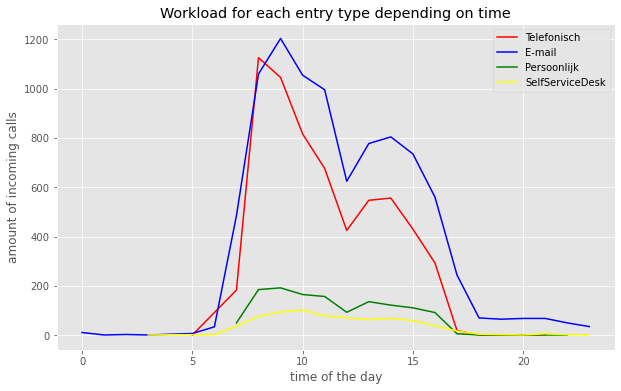

In [50]:
entrycount = df['Entry'].nunique()
entrytypes = df['Entry'].unique()
color = ['red', 'blue', 'green', 'yellow']

for i in range(entrycount):
    subdf = df[df['Entry']==entrytypes[i]]
    
    subdf_count = subdf.groupby('creation hour of day')
    subdf_count = subdf_count.count()
    plt.plot(subdf_count['Line'], label = entrytypes[i], color=color[i])

plt.xlabel('time of the day')
plt.ylabel('amount of incoming calls')
plt.title('Workload for each entry type depending on time')
plt.legend()

You can clearly see the working hours of the employees within the company, you can also see that after a certain time (probably lunch time) there is a decrease in the amount of incoming calls. Most calls are incoming by phone or e-mail however the ratio between these amounts does not seem to change overtime.

Text(0.5, 1.0, 'amount of incoming calls each month')

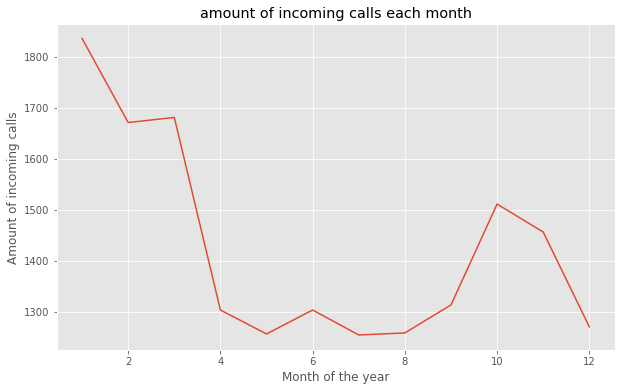

In [70]:
monthly_count = df.groupby('monthly incoming')
monthly_count = monthly_count.count()
plt.plot(monthly_count['Line'])
plt.xlabel('Month of the year')
plt.ylabel('Amount of incoming calls')
plt.title('amount of incoming calls each month')

You can clearly see that in the beginning and end of the year, there are incoming calls then in the middle of the year. This could be explained that during the summer more people are on holidays, but it is good to know that especially at the start of the year to schedule more employees to handle the extra workload.

Text(0.5, 1.0, 'amount of incoming calls each week of the year')

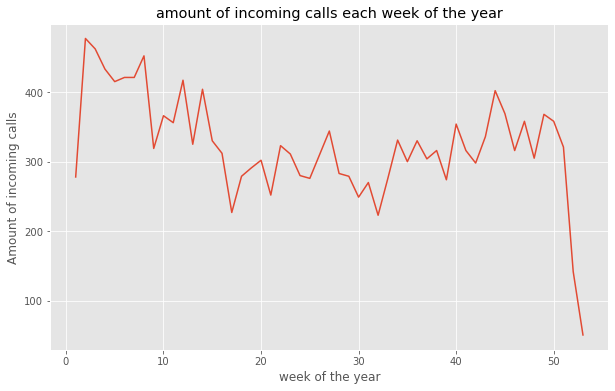

In [81]:
yearly_count = df.groupby('creation day of year')
yearly_count = yearly_count.count()

plt.plot(yearly_count['Line'])
plt.xlabel('week of the year')
plt.ylabel('Amount of incoming calls')
plt.title('amount of incoming calls each week of the year')

Similar results can be seen when the data is grouped by the amount of weeks in a year, however it is not as strong compared to when looking at the monthly relationship.

Text(0.5, 1.0, 'amount of incoming calls each weekday')

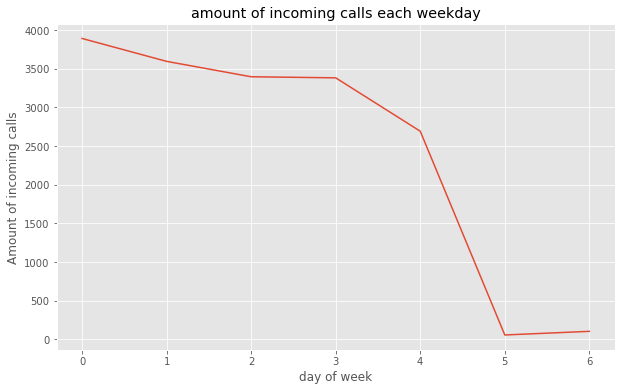

In [85]:
weekly_count = df.groupby('creation day of week')
weekly_count = weekly_count.count()
plt.plot(weekly_count['Line'])
plt.xlabel('day of week')
plt.ylabel('Amount of incoming calls')
plt.title('amount of incoming calls each weekday')

At the start of the week most calls are incoming, on friday it already drops because people go home early and in the weekend there are almost no incoming calls.

#### Now we implement a time series analysis to find a seasonality based on the workload

In [138]:
#round the dates to hours
df['Date/time of creation rounded']= df['Date/time of creation'].dt.round("H")

#Todo also add dates that are not occurring and set them to 0

time_series_df = df.groupby('Date/time of creation rounded').count()

time_series_df.head()


,Line,Status,Target date,Category,Subcategory,Call Type,Department.1,Operator Group,Date/time of creation,Closure Date,...,actual duration,actual duration seconds,actual duration minutes,Line_Type_num,creation hour of day,creation day of month,creation day of day,creation day of year,monthly incoming,creation day of week
Date/time of creation rounded,,,,,,,,,,,,,,,,,,,,,
2014-12-11 15:00:00,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2014-12-12 16:00:00,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2014-12-18 16:00:00,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2014-12-19 09:00:00,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2014-12-23 10:00:00,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [142]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 24  # daily seasonality
model = 'additive'

decomposition = seasonal_decompose(
    time_series_df['Line'].interpolate("linear"),
    freq=decompfreq,
    model=model)

trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

<ipython-input-142-3f752d012174>:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(


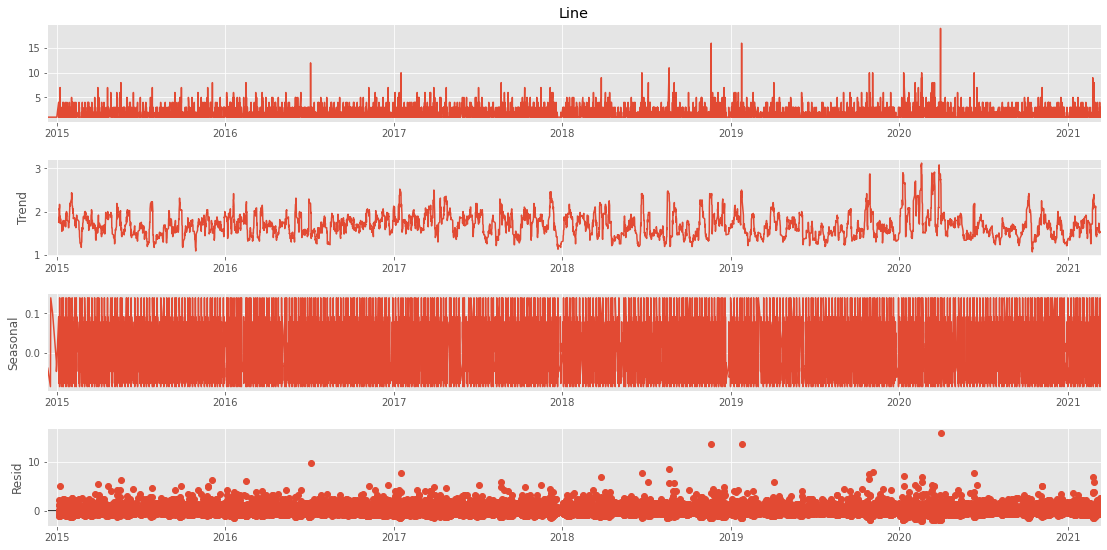

In [143]:
fig = decomposition.plot()
fig.set_size_inches(16, 8)

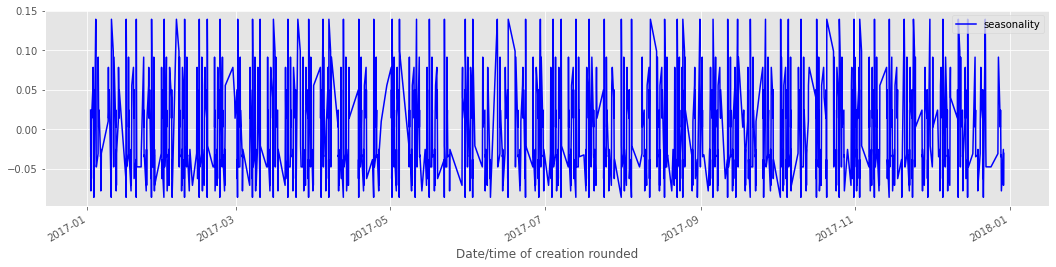

In [144]:
zoom_range = time_series_df.reset_index()[(time_series_df.reset_index()["Date/time of creation rounded"]>=np.datetime64('2017-01-01')) & (time_series_df.reset_index()["Date/time of creation rounded"]<np.datetime64('2018-01-01'))].index
indices = time_series_df.iloc[zoom_range]
indices = indices.index
fig, ax = plt.subplots(figsize=(18,4))
seasonal[indices].plot(ax=ax, label="seasonality", color="blue")
plt.legend()

It is not possible to see any seasonality in this plot, hence a second plot will be created over a shorter period of time to see more details.

KeyError: "None of [DatetimeIndex(['2017-01-02 09:26:20', '2017-01-02 08:50:15',\n               '2017-01-02 09:09:07', '2017-01-02 09:36:11',\n               '2017-01-02 10:22:14', '2017-01-02 10:40:54',\n               '2017-01-02 11:40:29', '2017-01-02 12:00:51',\n               '2017-01-02 13:43:54', '2017-01-02 13:58:02',\n               ...\n               '2018-12-28 07:45:27', '2018-12-28 10:26:53',\n               '2018-12-28 10:42:52', '2018-12-28 11:07:16',\n               '2018-12-28 13:52:43', '2018-12-31 08:56:10',\n               '2018-12-31 09:49:54', '2018-12-31 10:11:43',\n               '2018-12-31 13:34:52', '2018-12-31 14:22:37'],\n              dtype='datetime64[ns]', name='Date/time of creation', length=5569, freq=None)] are in the [index]"

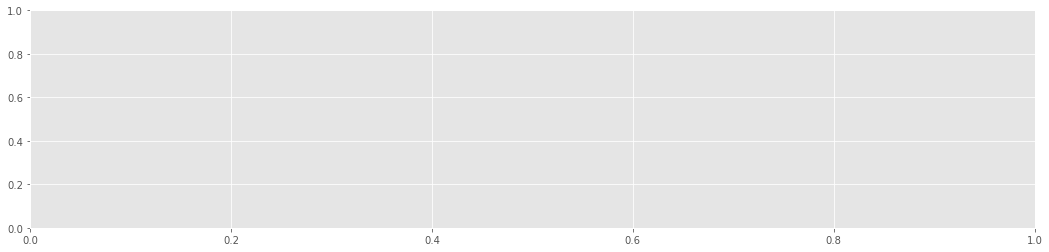

In [137]:
zoom_range = df[(df["Date/time of creation"]>=np.datetime64('2017-01-01')) & (df["Date/time of creation"]<np.datetime64('2019-01-01'))].index
indices = df.loc[zoom_range].set_index("Date/time of creation")
indices = indices.index
fig, ax = plt.subplots(figsize=(18,4))
seasonal[indices].plot(ax=ax, label="seasonality", color="blue")
plt.legend()

#### We now want to look into the duration of calls on specifc hours of day

In [33]:
df['creation hour of day'] = df['Date/time of creation'].dt.hour

decompfreq = 24  # hourly seasonality
model = 'additive'

decomposition = seasonal_decompose(
    df.set_index("creation hour of day")['actual duration seconds'].interpolate("linear"),
    freq=decompfreq,
    model=model)

trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

<ipython-input-33-2d55ed60d048>:6: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(


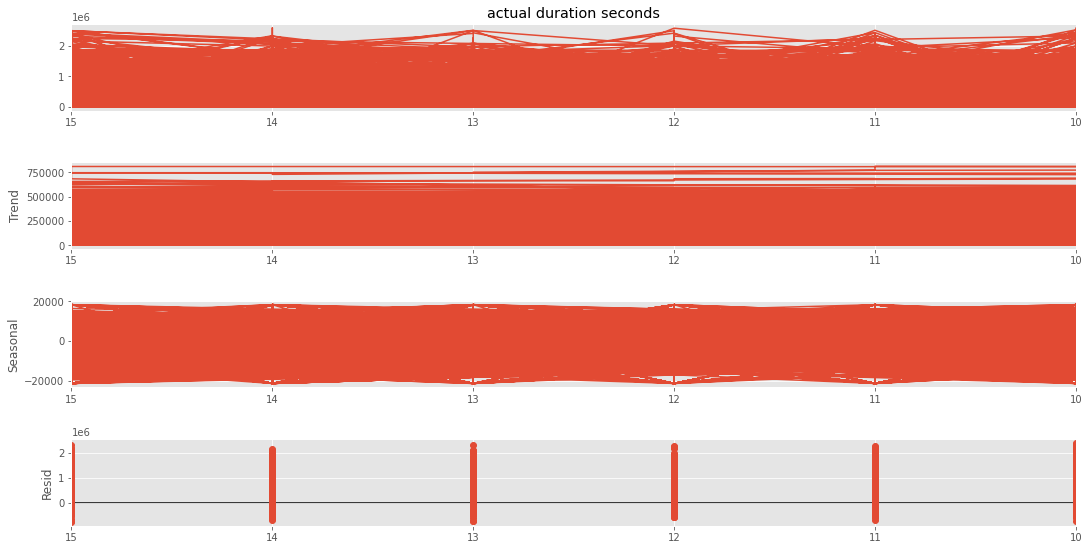

In [34]:
fig = decomposition.plot()
fig.set_size_inches(16, 8)

We cannot say anything about the duration of calls depended on what time they are incoming, so it's probably better to look at actual amount of incoming calls.

## Regression

In [39]:
regr = df
regr = pd.concat((regr, pd.get_dummies(regr['Entry'])), axis=1)
regr = regr.rename(columns = {'actual duration minutes': 'adm', 'E-mail': 'Email'}, inplace = False)
regr['Line'] = df['Line_Type_num']
regr

,Line,Status,Target date,Category,Subcategory,Call Type,Department.1,Operator Group,Date/time of creation,Closure Date,...,Entry,actual duration,actual duration seconds,adm,Line_Type_num,creation hour of day,Email,Persoonlijk,SelfServiceDesk,Telefonisch
14,1,Afgehandeld,2015-01-30 15:13:00,ICT Overige applicaties,Java,ICT Verstoring,Inkoop & Financiën - Financiën - BO,ICT Technisch beheer,2014-12-11 15:29:22,2015-01-08 08:15:00,...,Telefonisch,27 days 16:45:38,2393138.0,39885.633333,1,15,0,0,0,1
15,1,Afgehandeld,2014-12-23 16:24:00,ICT Overige applicaties,Internet Explorer,ICT Verstoring,Inkoop & Financiën - Inkoop - BO,ICT Technisch beheer,2014-12-12 16:24:13,2015-01-06 11:06:00,...,E-mail,24 days 18:41:47,2140907.0,35681.783333,1,16,1,0,0,0
20,1,Afgehandeld,2014-12-24 19:00:00,ICT MS Applicaties,Outlook,ICT Verstoring,Productie - K&O,ICT Technisch beheer,2014-12-18 16:18:43,2015-01-06 11:06:00,...,E-mail,18 days 18:47:17,1622837.0,27047.283333,1,16,1,0,0,0
21,1,Afgehandeld,2015-01-16 18:56:00,ICT Werkplek,Laptop,ICT Verstoring,Distributie - P&W Distributie - K&O,ICT ServiceDesk,2014-12-19 09:01:22,2015-01-16 15:31:00,...,Telefonisch,28 days 06:29:38,2442578.0,40709.633333,1,9,0,0,0,1
25,1,Afgehandeld,2015-01-14 17:00:00,ICT Telefonie,Smartphone,ICT Verstoring,Onderhoud & Inspectie - Onderhoud - K&O,ICT ServiceDesk,2014-12-23 10:20:55,2015-01-14 12:04:00,...,Telefonisch,22 days 01:43:05,1906985.0,31783.083333,1,10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48998,0,Afgehandeld,2021-03-11 19:00:00,ICT Infra,Windows account / AD,ICT Vraag,Personeel & Advisering - HRM - BO,ICT ServiceDesk,2021-03-11 10:29:02,2021-03-11 16:00:00,...,E-mail,0 days 05:30:58,19858.0,330.966667,0,10,1,0,0,0
49000,0,Afgehandeld,2021-03-11 15:48:00,ICT Telefonie,Smartphone,ICT Vraag,Personeel & Advisering - KAM - BO,ICT ServiceDesk,2021-03-11 11:48:25,2021-03-11 12:04:00,...,E-mail,0 days 00:15:35,935.0,15.583333,0,11,1,0,0,0
49002,0,Afgehandeld,2021-03-11 16:06:00,ICT Telefonie,Vaste telefonie,ICT Service Request,Personeel & Advisering - KAM - BO,ICT ServiceDesk,2021-03-11 12:06:34,2021-03-11 12:24:00,...,E-mail,0 days 00:17:26,1046.0,17.433333,0,12,1,0,0,0
49008,1,Afgehandeld,2021-03-18 15:14:00,ICT GIS,Smallworld NRM,ICT Service Request,Aanleg leidingen - K&O,ICT GIS Functioneel Applicatiebeheer,2021-03-11 15:14:27,2021-03-12 15:02:00,...,E-mail,0 days 23:47:33,85653.0,1427.550000,1,15,1,0,0,0


In [40]:
sp_duration_Entry = sm.ols(formula="adm ~ Email + Persoonlijk + SelfServiceDesk + Telefonisch + Line", data=regr).fit()
sp_duration_Email = sm.ols(formula="adm ~ Line", data=regr).fit()

print(sp_duration_Entry.summary())
print(sp_duration_Email.summary())


                            OLS Regression Results                            
Dep. Variable:                    adm   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     1281.
Date:                Thu, 18 Mar 2021   Prob (F-statistic):               0.00
Time:                        11:13:10   Log-Likelihood:            -1.7217e+05
No. Observations:               17112   AIC:                         3.444e+05
Df Residuals:                   17106   BIC:                         3.444e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.515e+15   1.59e+15     

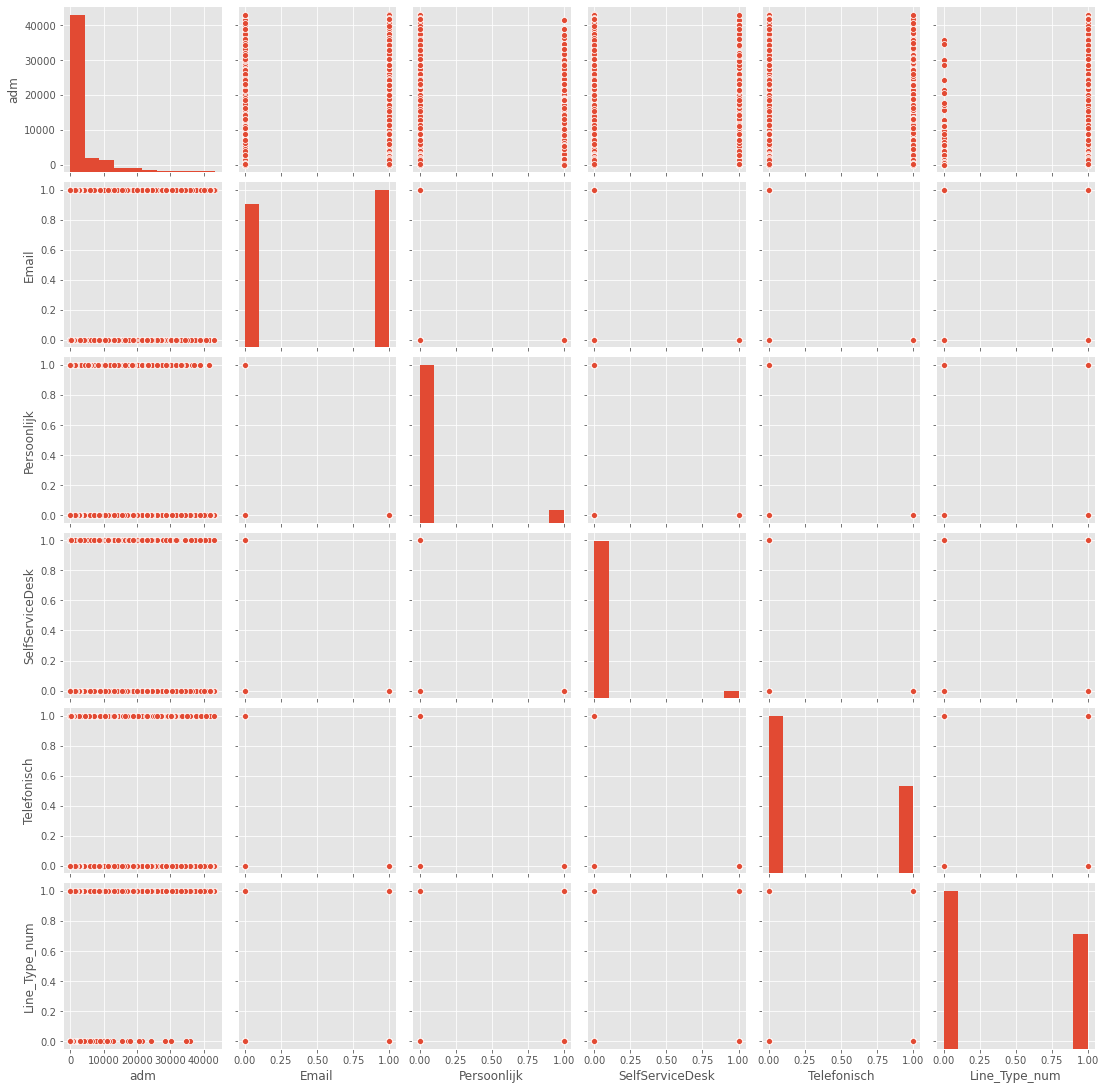

In [41]:
sns.pairplot(regr[['adm', 'Email', 'Persoonlijk', 'SelfServiceDesk', 'Telefonisch', 'Line_Type_num']]);